# Forecasting with a Bespoke Model, with a deeper look at errors.

The errors calculated in the last notebook where very low and probably not representative of the real uncertainty in the model/

In this notebook, the errors are mostly corrected using the uncertainties package in python; this isn't the most reliable package and I wouldn't fully trust it, however it is fine for simple forecasting. To be thorough, you would really need to do a grid search method, but this takes too much time.

This notebook is almost identical to the previous one, except for the error calculation.


### Import packages, read pickle

In [28]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os import path
import pickle
import scipy.optimize as opt
from uncertainties import ufloat
from uncertainties.umath import *
import datetime
pd.options.display.max_seq_items = 2000

In [29]:
openfile=open( r"C:\Users\Joseph\Documents\Beamly\TakeHomeTask\beamly_case_study_noNaNs.pickle", "rb")
df=pickle.load(openfile)
openfile.close()

### Create New Line

Create the sales estimate function, apply this function, drop the last date (as not a full day of transactions).

In [30]:

def salescount_poisson(B12,B23):
    """
    Function to estimate sales for the productBand 30to40 using two other product bands.
    """
    var1,var2=0.7552276624532916,0.5290400984433794
    return (var1*B12+var2*B23)/2.


In [31]:
forecast_august=df.groupby(by=['productBand', 'date']).sum()['total_products'].unstack(0)
forecast_august['between30and40']=forecast_august.apply(lambda x:salescount_poisson(x['between10and20'],x['between20and30']),axis=1)
forecast_august.drop(forecast_august.index[len(forecast_august)-1],inplace=True)

## Forecast New Line
Estimate the sales of the new line by creating a forecasting model.

A moving average function is used to smooth the data again.

In [32]:
def movingaverage(interval, window_size):
    """ 
    A function to calculate a moving average, useful for looking at data trends and for dampening noise in a less artificial way.
    """
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

Again, the model used is a simple sine function

In [33]:
def monthly_trend_forecaster(t,x):
    return x[0]*np.sin(x[1]*t+x[2]) + x[3]

In [34]:
forecast_august.reset_index(inplace=True)

## Long term trend fit
Perform the fit

In [35]:
#between20and30 first
y=movingaverage(forecast_august['between30and40'].values,6)
x1=forecast_august.index
guess_mean = np.mean(y)
guess_phase = 0
guess_freq = 0.3
guess_amp = 1
guess= [guess_amp, guess_freq, guess_phase, guess_mean]
errfunc = lambda o, x1, y: monthly_trend_forecaster(x1,o) - y # Distance to the target function, through linear combination.
fullout = opt.leastsq(errfunc, guess[:], args=(x1, y),full_output=1)
o1,cov_o1,infodict,mesg,ier=fullout
perr = np.sqrt(np.diag(cov_o1))
print(o1,perr)
print(np.mean(y))

[-6.39074530e+01  9.86779146e-02 -4.29298086e+00  1.73352286e+02] [0.53500834 0.00078601 0.02181078 0.63348472]
193.40301110216186


### New Error Estimation
Errors are now estimated by assigning errors to each parameter in the fitted model using the uncertainties package and then propagating theses errors using the same package.

Assign errors for the long term trend first, then later in the notebook we will propagate the errors.

In [36]:
#associate o1 with errors
# ltt=Long Term Trend
ltt_ampl = ufloat(o1[0],perr[0])
ltt_freq = ufloat(o1[1],perr[1])
ltt_phas = ufloat(o1[2],perr[2])
ltt_mean = ufloat(o1[3],perr[3])
ltt_paras= [ltt_ampl, ltt_freq, ltt_phas, ltt_mean]

Old way of calculating errors is still performed for a comparison:

In [37]:
error_comb_o1=np.sqrt((perr[0]/o1[0])**2+(perr[1]/o1[1])**2+(perr[2]/o1[2])**2)+(perr[3]/o1[3])
print(error_comb_o1)

0.016277449040313332


Plot the resulting fit

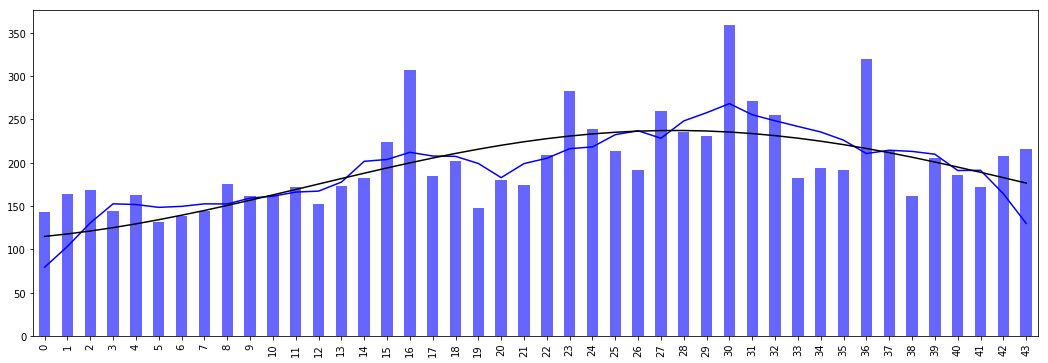

In [38]:
f, ax = plt.subplots(1,figsize=(18,6))
forecast_august['between30and40'].plot(kind='bar', ax=ax,color='blue',alpha=0.6,label='between30and40')
ax.plot(y,color='blue')
ax.plot(x1,monthly_trend_forecaster(x1,o1),color='k')

## Short term trend fit

[ 31.27749142   0.92703647  -1.35993183 197.7715822 ] [[ 4.56080589e-02 -4.79530431e-06  1.03809143e-04  6.36301436e-04]
 [-4.79530431e-06  2.88493349e-07 -6.29788265e-06  2.34550713e-08]
 [ 1.03809143e-04 -6.29788265e-06  1.84113362e-04 -7.17871218e-05]
 [ 6.36301436e-04  2.34550713e-08 -7.17871218e-05  2.28450892e-02]]
197.33508537980117


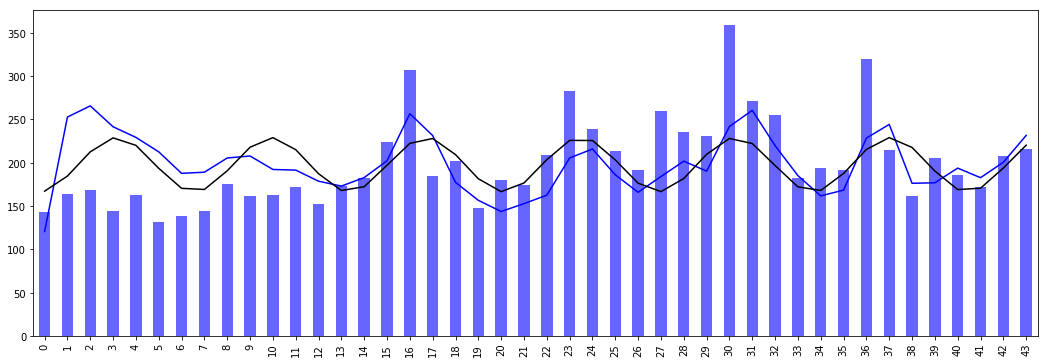

In [39]:
#between20and30 first
move_av_30to40=movingaverage(forecast_august['between30and40'].values,2)
y=move_av_30to40
x1=forecast_august.index
guess_mean = np.mean(y)
guess_std = 3*np.std(y)/(2**0.5)/(2**0.5)
guess_phase = 0
guess_freq =0.8
guess_amp = 1
guess= [guess_amp, guess_freq, guess_phase, guess_mean]
errfunc = lambda o, x1, y: monthly_trend_forecaster(x1,o) - y # Distance to the target function, through linear combination.
fullout = opt.leastsq(errfunc, guess[:], args=(x1, y),full_output=1)
o2,cov_o2,infodict,mesg,ier=fullout
perr2 = np.sqrt(np.diag(cov_o2))
print(o2,cov_o2)
print(np.mean(y))
f, ax = plt.subplots(1,figsize=(18,6))
forecast_august['between30and40'].plot(kind='bar', ax=ax,color='blue',alpha=0.6,label='between30and40')
ax.plot(move_av_30to40/(monthly_trend_forecaster(x1,o1)/np.mean(monthly_trend_forecaster(x1,o1))),color='blue')
ax.plot(x1,monthly_trend_forecaster(x1,o2),color='k')

### New Error Estimation
Again, we calculate errors for the second trend fit, using the uncertainties package.

In [40]:
#associate o1 with errors
# ltt=Short Term Trend
stt_ampl = ufloat(o2[0],perr2[0])
stt_freq = ufloat(o2[1],perr2[1])
stt_phas = ufloat(o2[2],perr2[2])
stt_mean = ufloat(o2[3],perr2[3])
stt_paras= [stt_ampl, stt_freq, stt_phas, stt_mean]

Have the comparison errors from the previous notebook as:

In [41]:
error_comb_o2=np.sqrt((perr2[0]/o2[0])**2+(perr2[1]/o2[1])**2+(perr2[2]/o2[2])**2)+(perr2[3]/o2[3])
print(error_comb_o2)

0.012868315343214741


In [42]:
error_percent_tot=np.sqrt(error_comb_o1**2+error_comb_o2**2)

## Combine Models
Combine the two fitted sine functions

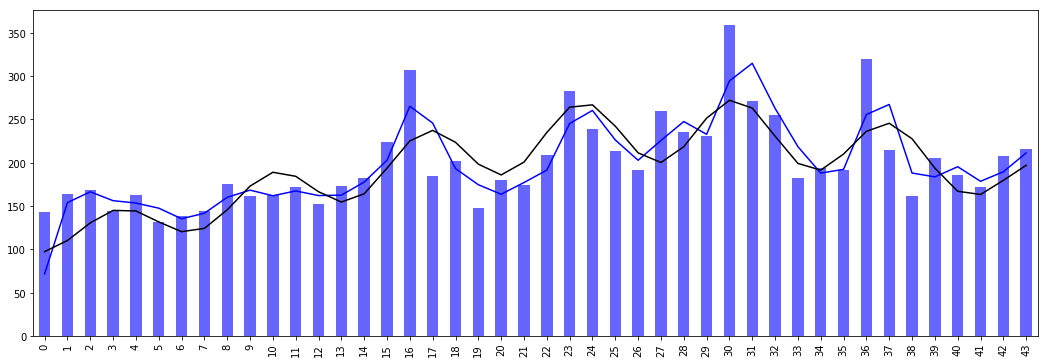

In [43]:
#def comb_func(x1,o1,o2):
#    return (monthly_trend_forecaster(x1,o1)+monthly_trend_forecaster(x1,o2))/2.#This dampens the signal a little, better to use the lower function
def comb_func(x1,o1,o2):
    return (monthly_trend_forecaster(x1,o1)*monthly_trend_forecaster(x1,o2))/np.mean(monthly_trend_forecaster(x1,o2))
f, ax = plt.subplots(1,figsize=(18,6))
forecast_august['between30and40'].plot(kind='bar', ax=ax,color='blue',alpha=0.6,label='between30and40')
ax.plot(move_av_30to40,color='blue')
ax.plot(x1,comb_func(x1,o1,o2),color='k')#this worked before, but not good errors

## Forecast Sales for last two weeks
Now we have modelled the current dataset, we can use this to predict the sales in the future for any productBand. Although we will just do the band 30to40.


##### Note: 
The model does not use the timestamp, but just day, starting from 0. We want to model the last two weeks of August, in coding terms this is from days 44->60

In [44]:
newdates=np.arange(44,61,1)
b34sales=comb_func(newdates,o1,o2)

In [45]:
df_b34=pd.DataFrame(b34sales,index=newdates)

Assign new dates to the forecast sales

In [46]:
def assigndates(row):
    r44=pd.to_datetime('2018-08-14')
    year = r44.year
    month = r44.month
    day = r44.day+(row.name-44)
    return datetime.date(year, month, day)
df_b34['date']=df_b34.apply(lambda row:assigndates(row),axis=1);

Transform the dataframe a little, set the index, drop old index, rename a column.

In [47]:
df_b34.reset_index(inplace=True)
df_b34.set_index('date',inplace=True)

In [48]:
df_b34.drop(['index'],axis=1,inplace=True)

In [49]:
df_b34.rename(columns={0: "forecast_B30to40"},inplace=True)

# Error Estimation
Need to create two new functions to calculate the combined dales forecast with errors. The functions need to use the uncertainties package for some of the calculation.

In [50]:
def monthly_trend_forecaster(t,x):
    x1in=x[1]*t
    return x[0]*sin(x1in+x[2]) + x[3]
def error_forecaster(t,para1,para2):
    print(sin(para1[1]*t+para1[2]),t)
    return sqrt(monthly_trend_forecaster(t,para1)**2+monthly_trend_forecaster(t,para2)**2).s
df_b34['forecast_error']=df_b34["forecast_B30to40"].apply(lambda x:error_forecaster(x,ltt_paras,stt_paras))

0.64+/-0.12 195.69425358685118
0.40+/-0.13 175.02535596546718
-0.65+/-0.09 146.2451752552382
0.91+/-0.04 127.50173602603465
0.89+/-0.05 127.94203979917621
-0.23+/-0.11 141.39639890860977
-0.968+/-0.031 152.36482944887547
-0.82+/-0.07 148.6712549673635
0.74+/-0.07 130.55295431148184
0.24+/-0.09 109.58374590179517
-0.72+/-0.06 99.09321831572731
-0.31+/-0.08 103.96422029051658
0.85+/-0.05 117.47565631110366
0.93+/-0.04 127.03674345361163
0.996+/-0.009 124.00457730589088
0.29+/-0.09 110.11547789948074
-0.896+/-0.035 95.9258132284542


This is quite a novel way of calculating errors, but I'm not completely convinced. This package gives +- as the same value, this is technically the standard deviation and not strictly the error, hence the values are symmetric when really this is not possible. However for our forecasting, this should be good enough.

Apply the forecasting error:

In [51]:
df_b34['forecast_error']=df_b34.apply(lambda x:x*error_percent_tot);

# Plot of Sales Forecast
This is the final result of the task, a predction of the sales for a brand new line in the last two weeks of August.

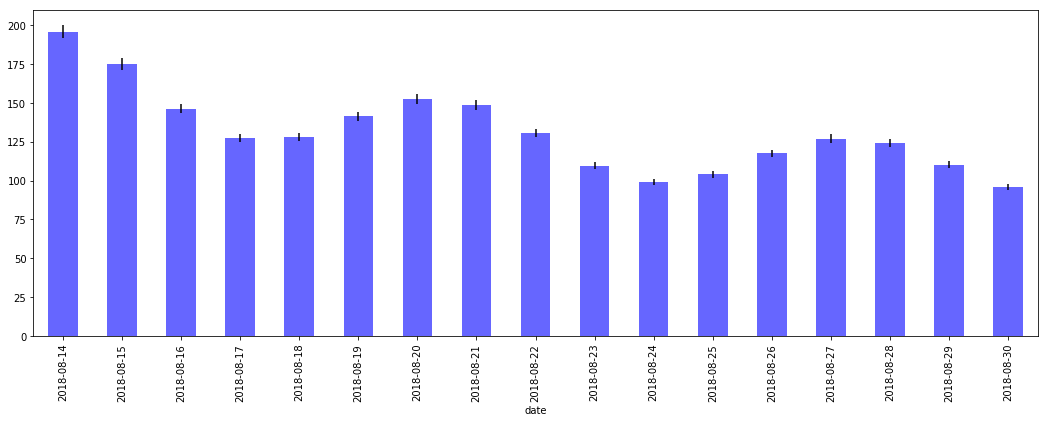

In [52]:
f, ax = plt.subplots(1,figsize=(18,6))
df_b34['forecast_B30to40'].plot(kind='bar',yerr=df_b34['forecast_error'], ax=ax,color='blue',alpha=0.6,label='Forecast_30to40')

The errors are very small, this shows that we may need an even more in depth method to work out the uncertainty in the model. The best way to work out the error on this would be to use a grid search method, but that would take a lot of time to build right now, so this will have to do.

### Sales Figures
For the README, I wanted to give a  quick estimate of the total products sold in the last two weeks of August for the new line, and the revenue from those sales. 

This is what is being calculated below, with the first number being total products sold and the second being total products sold times £35 (as this is what we were modelling on as the average price).

In [53]:
print(df_b34['forecast_B30to40'].sum(),df_b34['forecast_B30to40'].sum()*35)

2232.593450975678 78140.77078414873
